In [ ]:
!pip install torchmetrics
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 49.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset

from tqdm.notebook import tqdm
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
zip_depth_ir_pm_path = '/content/drive/MyDrive/SKKU_2-2 URP/[2] Pressure_Sore_Dataset/SLP_Dataset_RGB_PM/Depth_IR_PM.zip'
unzip_depth_ir_pm_path = '/content/Depth_IR_PM'

os.makedirs(unzip_depth_ir_pm_path, exist_ok=True)
with zipfile.ZipFile(zip_depth_ir_pm_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_depth_ir_pm_path)

# **Dataset**

In [ ]:
class IR_PM_Dataset(Dataset):
    def __init__(self, ir_folder, pm_folder, transform):
        """
        적외선(IR) 이미지와 압력맵(PM) 이미지를 불러와서 변환하는 데이터셋 클래스입니다.
        """
        self.ir_folder = ir_folder
        self.pm_folder = pm_folder

        self.ir_images = sorted(os.listdir(self.ir_folder))
        self.pm_images = sorted(os.listdir(self.pm_folder))

        self.transform = transform

    def __len__(self):
        return len(self.pm_images)

    def __getitem__(self, idx):
        """
        적외선 이미지와 압력맵 이미지를 불러와서 정규화 및 스케일링을 진행하고 반환합니다.
        """
        # ir image
        ir_path = os.path.join(self.ir_folder, self.ir_images[idx])
        ir_img = Image.open(ir_path).convert('RGB')
        ir_img = self.normalize_scale(ir_img) # 정규화 및 스케일링

        # Pressure map
        pm_path = os.path.join(self.pm_folder, self.pm_images[idx])
        pm_img = Image.open(pm_path)
        pm_img = self.normalize_scale(pm_img) # 정규화 및 스케일링

        ir_img, pm_img = self.transform(ir_img), self.transform(pm_img)
        return ir_img, pm_img

    def normalize_scale(self, img):
        """
        적외선 이미지에서는 사람과 배경 간의 밝기 차이가 나타날 수 있도록 밝기 조정을 수행합니다.
        또한, 압력맵 이미지에서도 배경(압력이 없는 곳)과 사람(압력이 있는 곳) 간의 압력 차이가 명확히 나타날 수 있도록 밝기 조정을 수행합니다.
        """
        img = np.array(img)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8) # [0, 1] 범위로 정규화

        # 압력맵 이미지
        if len(img.shape) == 2:
            img = np.power(img, 0.5)

        # 적외선 이미지
        else:
            img = np.power(img, 0.75)

        # 이미지 픽셀 값을 0~255 사이로 클리핑 후, 정수형으로 변환
        img = np.clip(img * 255, 0, 255).astype(np.uint8)
        return img

In [ ]:
ir_path = '/content/Depth_IR_PM/IR_png'
pm_path = '/content/Depth_IR_PM/PM_png'

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])

dataset = IR_PM_Dataset(ir_path, pm_path, transform)

In [ ]:
"""
훈련 데이터 크기: 전체 데이터셋의 80%
검증 데이터 크기: 전체 데이터셋의 10%
테스트 데이터 크기: 전체 데이터셋의 10%
"""

data_size = len(dataset)
train_size = int(data_size * 0.8)
val_size = int(data_size * 0.1)
test_size = data_size - train_size - val_size

train_indices = list(range(0, train_size))
val_indices = list(range(train_size, val_size + train_size))
test_indices = list(range(val_size + train_size, data_size))

In [ ]:
print('Train samples:', train_size)
print('Val samples:', val_size)
print('Test samples:', test_size)

Train samples: 10800
Val samples: 1350
Test samples: 1350


In [ ]:
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [ ]:
"""
훈련 데이터가 약 1만장이므로, 배치 크기는 32로 설정
"""

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Infrared image shape: torch.Size([3, 224, 224])
Pressure map shape: torch.Size([1, 224, 224])


Text(0.5, 1.0, 'Pressure Map (Ground Truth)')

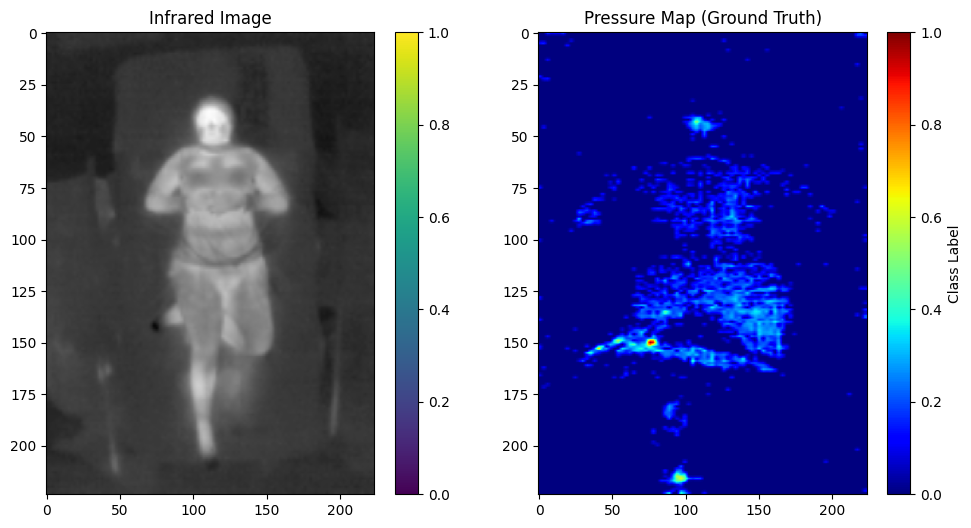

In [ ]:
ir_sample, pm_sample = next(iter(train_loader))

ir_sample = ir_sample[0]
pm_sample = pm_sample[0]

print('Infrared image shape:', ir_sample.shape)
print('Pressure map shape:', pm_sample.shape)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(ir_sample.permute(1, 2, 0), cmap='viridis', vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.title('Infrared Image')

plt.subplot(1, 3, 2)
plt.imshow(pm_sample.squeeze(0), cmap='jet', vmin=0, vmax=1, aspect='auto')
plt.colorbar(label='Class Label')
plt.title('Pressure Map (Ground Truth)')

# **Model**

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

class TransUNet(nn.Module):
    """
    Vision Transformer (ViT)을 기반으로 한 U-Net 모델.
    ViT를 백본으로 사용하고, U-Net 스타일의 인코더-디코더 아키텍처를 결합하여 이미지 세그멘테이션을 수행.
    """
    def __init__(self, num_classes=1):
        super(TransUNet, self).__init__()

        weights = ViT_B_16_Weights.DEFAULT
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()
        vit_dim = self.vit.hidden_dim
        self.cls_token = nn.Parameter(torch.zeros(1, 1, vit_dim))

        self.encoder1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.encoder2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.encoder3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.encoder4 = nn.Conv2d(256, 768, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))

        self.upconv1 = nn.ConvTranspose2d(768, 256, kernel_size=2, stride=2)
        self.decoder1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        x = self.adaptive_pool(enc4)

        b, c, h, w = x.shape
        x = x.flatten(2).transpose(1, 2)

        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.vit.encoder(x)
        x = x[:, 1:, :]
        x = x.permute(0, 2, 1).view(b, -1, h, w)

        x = F.interpolate(x, size=enc4.shape[2:], mode="bilinear", align_corners=True)
        x = self.upconv1(x)
        x = torch.cat((x, enc3), dim=1)
        x = self.decoder1(x)

        x = F.interpolate(x, size=enc3.shape[2:], mode="bilinear", align_corners=True)
        x = self.upconv2(x)
        x = torch.cat((x, enc2), dim=1)
        x = self.decoder2(x)

        x = F.interpolate(x, size=enc2.shape[2:], mode="bilinear", align_corners=True)
        x = self.upconv3(x)
        x = torch.cat((x, enc1), dim=1)
        x = self.decoder3(x)

        x = self.output_conv(x)
        return x

model = TransUNet()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 218MB/s]


In [ ]:
print(model)

TransUNet(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNo

In [ ]:
# 모델의 전체 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())

# 학습 가능한 파라미터 수 계산 (requires_grad=True인 파라미터들만 계산)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 90440001
Trainable parameters: 90440001


In [ ]:
from thop import profile

input_data = torch.randn(1, 3, 192, 96)
flops, params = profile(model, inputs=(input_data, ))

print(f"FLOPs: {flops / 1e9:.2f} G-Ops")
print(f"Parameters: {params / 1e6:.2f} M")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
FLOPs: 18.58 G-Ops
Parameters: 61.35 M


In [ ]:
model.eval()
with torch.no_grad():
    sample = torch.rand(1, 3, 224, 224)
    output = model(sample)
    print(output.shape)

torch.Size([1, 1, 224, 224])


In [ ]:
model = model.to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

# RMSE (Root Mean Squared Error) 계산 함수
def RMSE(y_pred, y_true):
    return torch.sqrt(F.mse_loss(y_pred, y_true))

In [ ]:
def train(model, data_loader, criterion, optimizer):
    # SSIM 지표 객체 생성 (데이터 범위 1.0 설정)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    model.train()
    train_loss = 0.0
    train_rmse = 0.0
    train_ssim = 0.0

    for inputs, labels in tqdm(data_loader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        rmse = RMSE(outputs, labels)
        train_rmse += rmse.item()

        ssim_score = ssim_metric(outputs, labels)
        train_ssim += ssim_score.item()

    train_loss /= len(data_loader)
    train_rmse /= len(data_loader)
    train_ssim /= len(data_loader)

    return train_loss, train_rmse, train_ssim

In [ ]:
def evaluate(model, data_loader, criterion):
    # SSIM 지표 객체 생성 (데이터 범위 1.0 설정)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    model.eval()
    eval_loss = 0.0
    eval_rmse = 0.0
    eval_ssim = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            eval_loss += loss.item()

            rmse = RMSE(outputs, labels)
            eval_rmse += rmse.item()

            ssim_score = ssim_metric(outputs, labels)
            eval_ssim += ssim_score.item()

    eval_loss /= len(data_loader)
    eval_rmse /= len(data_loader)
    eval_ssim /= len(data_loader)

    return eval_loss, eval_rmse, eval_ssim

In [ ]:
num_epochs = 50
train_results = {'Loss': [], 'RMSE': [], 'SSIM': []}
val_results = {'Loss': [], 'RMSE': [], 'SSIM': []}

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_rmse, train_ssim = train(model, train_loader, criterion, optimizer)
    val_loss, val_rmse, val_ssim = evaluate(model, val_loader, criterion)

    end_time = time.time()

    train_results['Loss'].append(train_loss)
    val_results['Loss'].append(val_loss)

    train_results['RMSE'].append(train_rmse)
    val_results['RMSE'].append(val_rmse)

    train_results['SSIM'].append(train_ssim)
    val_results['SSIM'].append(val_ssim)

    print(f"[Epoch {epoch + 1}/{num_epochs}, {int(end_time - start_time)}s]")
    print(f"Training Loss: {train_loss:.6f} | RMSE: {train_rmse:.4f} | SSIM: {train_ssim:.4f}")
    print(f"Validation Loss: {val_loss:.6f} | RMSE: {val_rmse:.4f} | SSIM: {val_ssim:.4f}")
    print("=" * 60)
    print()

In [ ]:
test_loss, test_rmse, test_ssim = evaluate(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.6f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test SSIM: {test_ssim:.4f}")

## **Result - Metrics (Loss, RMSE, SSIM)**

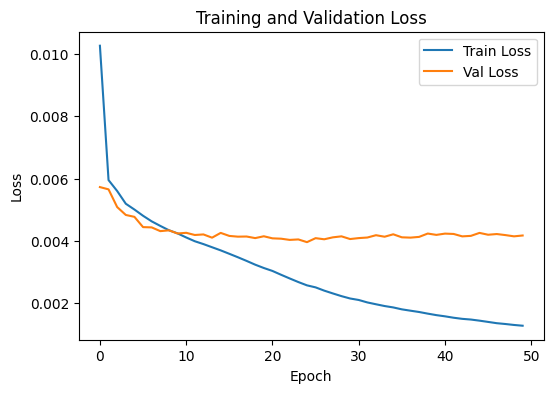

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_results['Loss'], label='Train Loss')
plt.plot(val_results['Loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

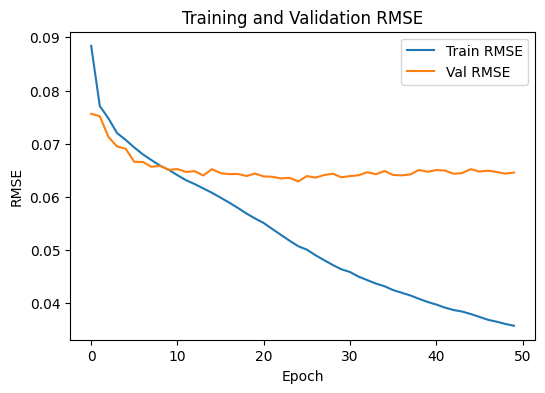

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_results['RMSE'], label='Train RMSE')
plt.plot(val_results['RMSE'], label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

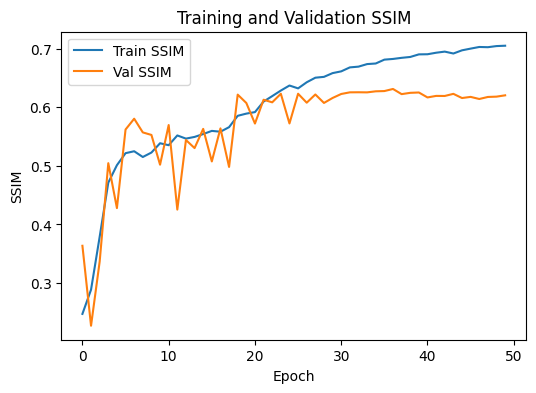

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_results['SSIM'], label='Train SSIM')
plt.plot(val_results['SSIM'], label='Val SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Training and Validation SSIM')
plt.legend()
plt.show()

# **Results - Prediction image**

In [ ]:
# 모델 예측 결과를 시각화하는 함수
def visualize_result(model, data_loader, is_data = 'Train'):
    # 데이터 로더의 첫번째 배치의 첫번째 데이터를 사용
    ir, pm_gt = next(iter(data_loader))
    ir = ir[0]
    pm_gt = pm_gt[0]

    with torch.no_grad():
        model.eval()

        ir = ir.unsqueeze(0).to(device)
        pm_pred = model(ir)
        pm_pred = pm_pred.cpu()

    # SSIM 및 RMSE 계산
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    rmse = RMSE(pm_pred, pm_gt.unsqueeze(0)).item()
    ssim = ssim_metric(pm_pred, pm_gt.unsqueeze(0)).item()

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(ir.squeeze(0).permute(1, 2, 0).cpu(), aspect='auto')
    plt.colorbar()

    if is_data == 'Train':
        plt.title('Infrared Image (Train)')
    elif is_data == 'Val':
        plt.title('Infrared Image (Validation)')
    elif is_data == 'Test':
        plt.title('Infrared Image (Test)')

    plt.subplot(1, 3, 2)
    plt.imshow(pm_gt.squeeze(0), cmap='jet', vmin=0, vmax=1, aspect='auto')
    plt.colorbar(label='Class Label')
    plt.title('Pressure Map (Ground Truth)')

    plt.subplot(1, 3, 3)
    plt.imshow(pm_pred.squeeze().numpy(), cmap='jet', vmin=0, vmax=1, aspect='auto')
    plt.colorbar(label='Class Label')
    plt.title(f'Pressure Map (Prediction)\nRMSE: {rmse:.4f}, SSIM: {ssim:.4f}')

    plt.tight_layout()
    plt.show()

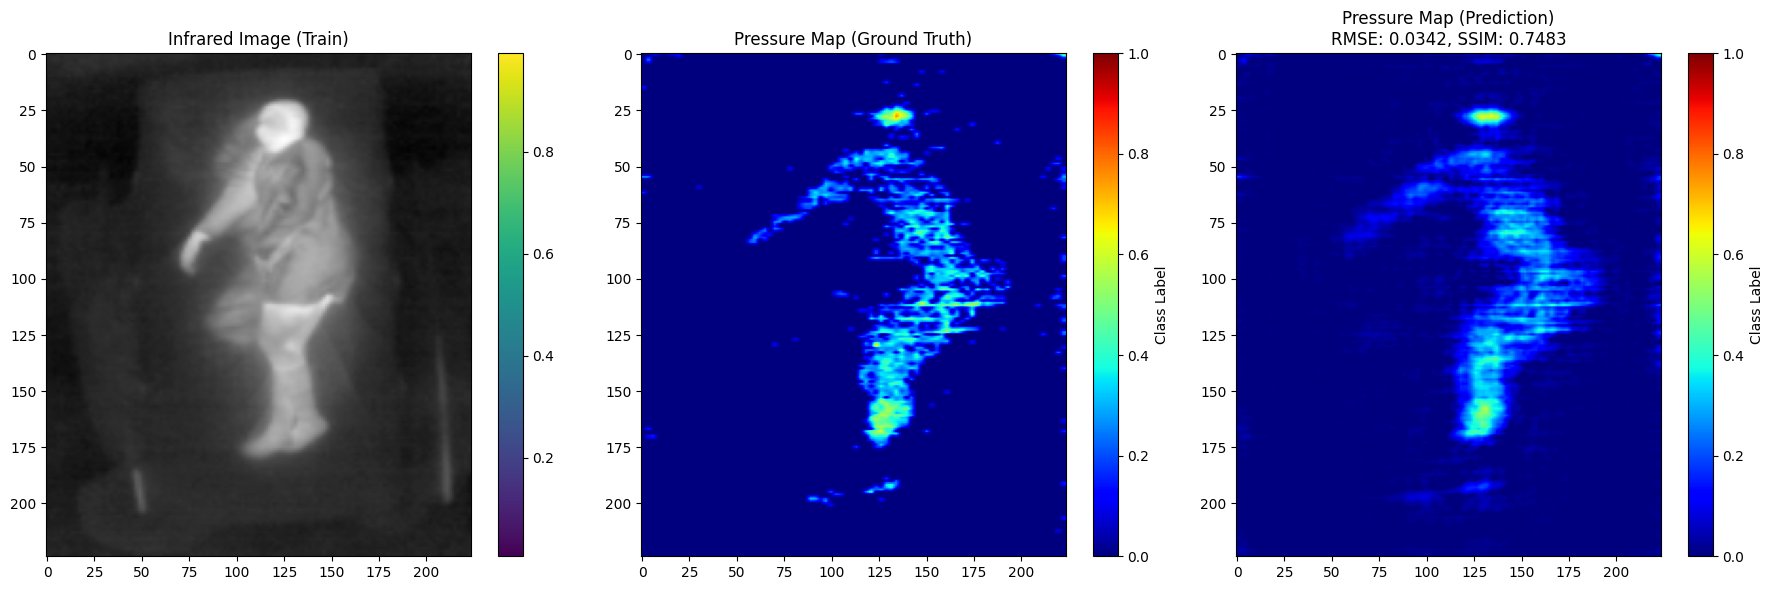

In [ ]:
# 훈련 데이터에 대한 결과 시각화
visualize_result(model, train_loader, 'Train')

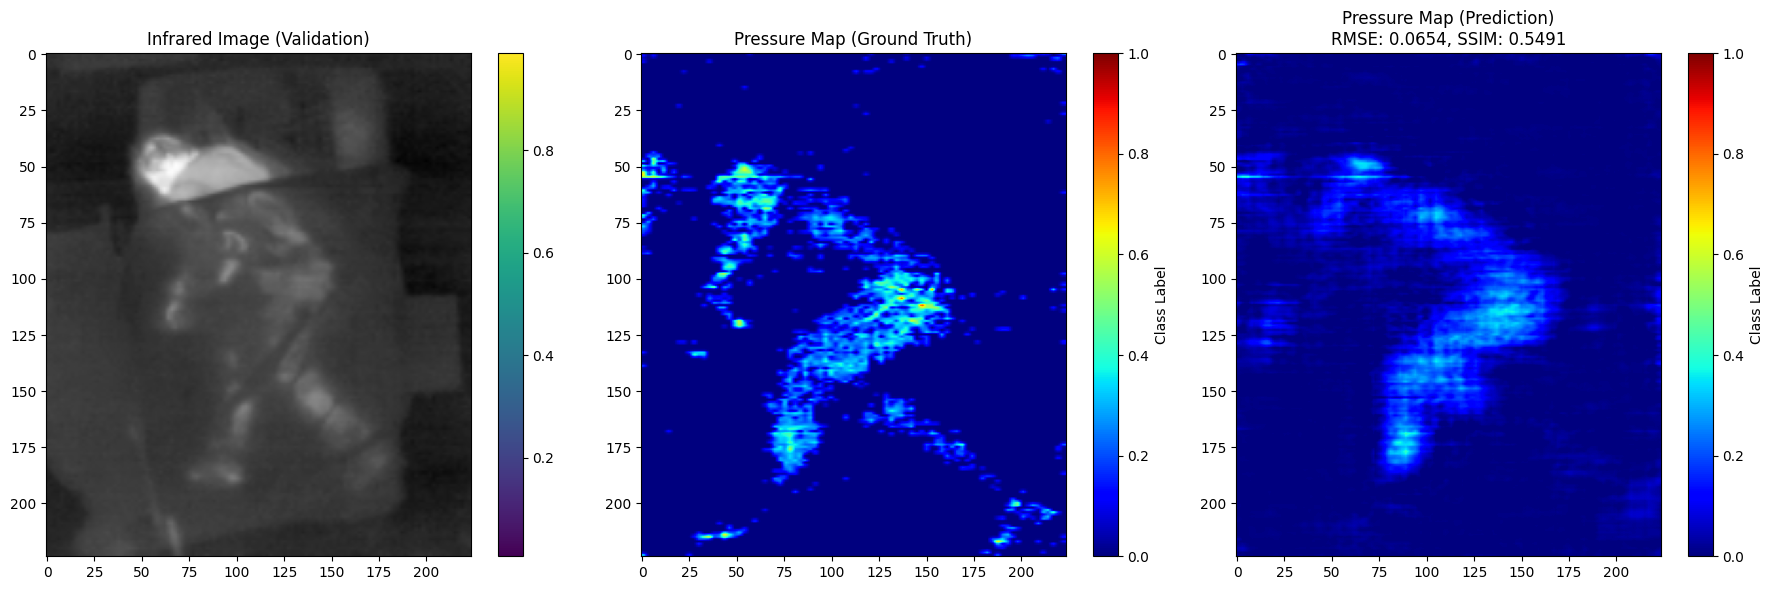

In [ ]:
# 검증 데이터에 대한 결과 시각화
visualize_result(model, val_loader, 'Val')

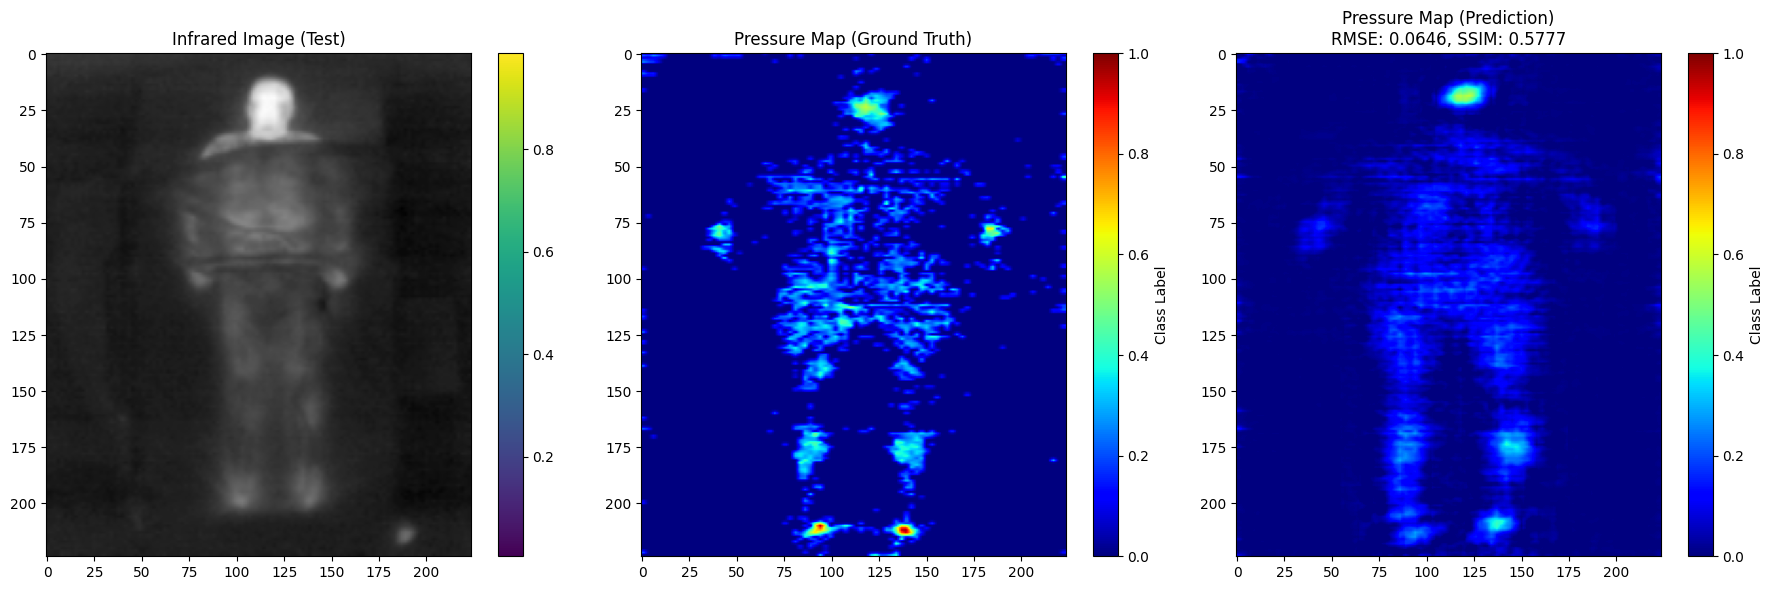

In [ ]:
# 테스트 데이터에 대한 결과 시각화
visualize_result(model, test_loader, 'Test')

In [ ]:
save_path = '/content/drive/MyDrive/SKKU_2-2 URP/[2] Pressure_Sore_Code/model_save/IR_PM_save (색 대비, 최종본)'
checkpoint_path = os.path.join(save_path, 'TransUNet_E50.pth')

if not os.path.exists(checkpoint_path):
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)
    print('model save 완료.')
else:
    print('model save 이미 완료.')

model save 완료.
